In [1]:

from google.colab import drive
drive.mount('/content/drive')
"""
Change directory to where this file is located
"""
%cd /content/drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


In [2]:
# To generate GIFs
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import requests
import tqdm
import shutil
import re
import cv2
import time
import logging

import glob
import imageio
from tensorflow.keras import layers
from IPython import display


In [3]:
class TqdmLoggingHandler(logging.Handler):
    def __init__(self, level=logging.NOTSET):
        super().__init__(level)

    def emit(self, record):
        try:
            msg = self.format(record)
            tqdm.tqdm.write(msg)
            self.flush()
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            self.handleError(record)  
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
log.addHandler(TqdmLoggingHandler())

In [4]:
@tf.function
def build_data(d):
  # hr=d['image']
  # data = tf.keras.layers.GaussianNoise()(data)

  lr=tf.image.resize(d,(64,64))
  #lr=tf.image.resize(lr,(128,128),method=tf.image.ResizeMethod.BICUBIC)
  return lr, d

In [5]:
def build(image):
  image=tf.image.resize(image['image'], (256,256))
  return tf.cast(image, tf.float32) / 255.

# def resize_image(image):
#   return 

In [6]:
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# BUFFER_SIZE = 60000
# BATCH_SIZE = 64

# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
data=tfds.load('aflw2k3d')
train_data=data['train'].skip(600)
test_data=data['train'].take(600)
tqdm.tqdm(train_data)
train_data=train_data.map(build)
test_data=test_data.map(build)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/aflw2k3d/1.0.0.incompleteOZ0814/aflw2k3d-train.tfrecord


  0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset aflw2k3d downloaded and prepared to /root/tensorflow_datasets/aflw2k3d/1.0.0. Subsequent calls will reuse this data.


  0%|          | 0/1400 [00:00<?, ?it/s]


In [ ]:
# class Generator:
#   def RRDB(input,ch=64,k_s=3,st=1):
#     block_1=tf.keras.layers.Conv2D(ch,k_s,st,padding='same')(input)
#     block_1=tf.keras.layers.LeakyReLU()(block_1)

#     block_2=tf.keras.layers.Add()([block_1, input])
#     block_2=tf.keras.layers.Conv2D(ch,k_s,st,padding='same')(block_2)
#     block_2=tf.keras.layers.LeakyReLU()(block_2)

#     block_3=tf.keras.layers.Add()([block_1, input])
#     block_3=tf.keras.layers.Add()([block_2, block_3])
#     block_3=tf.keras.layers.Conv2D(ch,k_s,st,padding='same')(block_3)
#     block_3=tf.keras.layers.LeakyReLU()(block_3)

#     block_4=tf.keras.layers.Add()([block_1, input])
#     block_4=tf.keras.layers.Add()([block_2, block_4])
#     block_4=tf.keras.layers.Add()([block_3, block_4])
#     block_4=tf.keras.layers.Conv2D(ch,k_s,st,padding='same')(block_4)
#     block_4=tf.keras.layers.LeakyReLU()(block_4)

#     block_5=tf.keras.layers.Add()([block_1, input])
#     block_5=tf.keras.layers.Add()([block_2, block_5])
#     block_5=tf.keras.layers.Add()([block_3, block_5])

#     out=block_2=tf.keras.layers.Conv2D(ch,k_s,st,padding='same')(block_5)
#     return out

#   def Upsample_block(input, ch=256, k_s=3, st=1):
#     input = tf.keras.layers.Conv2D(ch,k_s, strides=(st,st), padding='same')(input)
#     input = tf.nn.depth_to_space(input, 2) # Subpixel pixelshuffler
#     input = tf.keras.layers.LeakyReLU()(input)
#     return input

#   def __init__(self, input_shape):
#     input=tf.keras.layers.Input(shape=input_shape)
#     input_conv=tf.keras.layers.Conv2D(64,9,padding='same')(input)
#     input_conv=tf.keras.layers.LeakyReLU()(input_conv)
#     beta=0.7
#     SRRes=input_conv
#     for x in range(3):
#       res_output=Generator.RRDB(SRRes)
#       SRRes=tf.keras.layers.Add()([SRRes,beta*res_output])
#     SRRes=tf.keras.layers.Add()([SRRes,beta*input_conv])

#     SRRes=Generator.Upsample_block(SRRes)
#     SRRes=Generator.Upsample_block(SRRes)
#     # SRRes=Generator.Upsample_block(SRRes)
#     output_sr=tf.keras.layers.Conv2D(3,9,activation='tanh',padding='same')(SRRes)
#     self.model=tf.keras.models.Model(input,output_sr)

#   def __call__(self, image, training=False):
#     return self.model(image)


In [ ]:
# Input_shape=(64,64,3)
# generator = Generator(Input_shape)

# noise = tf.random.normal(Input_shape)
# generated_image = generator(tf.expand_dims(noise, axis=0), training=False)

# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [7]:
def residual_block_disc(ch=64,k_s=3,st=1):
  model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(ch,k_s,strides=(st,st),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
  ])
  return model

input_lr=tf.keras.layers.Input(shape=(256,256,3))
input_conv=tf.keras.layers.Conv2D(64,3,padding='same')(input_lr)
input_conv=tf.keras.layers.LeakyReLU()(input_conv)

channel_nums=[64,128,128,256,256,512,512]
stride_sizes=[2,1,2,1,2,1,2]

disc=input_conv
for x in range(7):
  disc=residual_block_disc(ch=channel_nums[x],st=stride_sizes[x])(disc)
  
disc=tf.keras.layers.Flatten()(disc)

disc=tf.keras.layers.Dense(1024)(disc)
disc=tf.keras.layers.LeakyReLU()(disc)

disc_output=tf.keras.layers.Dense(1,activation='sigmoid')(disc)

discriminator=tf.keras.models.Model(input_lr,disc_output)

In [ ]:
# INPUT_SHAPE=(256,256,3)
# discriminator = Discriminator(INPUT_SHAPE)
# decision = discriminator(generated_image)
# print (decision)

# # gen = Generator(INPUT_SHAPE)
# # gen.model.summary()

tf.Tensor([[0.49967974]], shape=(1, 1), dtype=float32)


In [8]:
VGG19=tf.keras.applications.VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

VGG_i,VGG_j=2,2
def VGG_loss(y_hr,y_sr,i_m=2,j_m=2):
  i,j=0,0
  accumulated_loss=0.0
  for l in VGG19.layers:
    cl_name=l.__class__.__name__
    if cl_name=='Conv2D':
      j+=1
    if cl_name=='MaxPooling2D':
      i+=1
      j=0
    if i==i_m and j==j_m:
      break
    
    config=l.get_config()
    print(config)
    y_hr=l(y_hr)
    y_sr=l(y_sr)
    if cl_name=='Conv2D':
      accumulated_loss+=tf.reduce_mean((y_hr-y_sr)**2) * 0.006

  return accumulated_loss

def VGG_loss_intuitive(y_true,y_pred):
  accumulated_loss=0.0
  for l in VGG19.layers:
    y_true=l(y_true)
    y_pred=l(y_pred)
    accumulated_loss+=tf.reduce_mean((y_true-y_pred)**2) * 0.006
  return accumulated_loss

80150528/80134624 [==============================] - 1s 0us/step


In [9]:
def PSNR(y_true,y_pred):
  mse=tf.reduce_mean( (y_true - y_pred) ** 2 )
  return 20 * log10(1 / (mse ** 0.5))

def log10(x):
  numerator = tf.math.log(x)
  denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
  return numerator / denominator

def pixel_MSE(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [10]:
generator_optimizer=tf.keras.optimizers.Adam(0.0001)
discriminator_optimizer=tf.keras.optimizers.Adam(0.0001)

adv_ratio=0.001
evaluate=['PSNR']
loss_func,adv_learning = lambda y_hr,y_sr:VGG_loss(y_hr,y_sr,i_m=5,j_m=4),True

In [27]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = tf.keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/captain-pool/esrgan-tf2/1", trainable=True),
    tf.keras.layers.Conv2D(filters=3, kernel_size=[1, 1], strides=[1, 1])
])

@tf.function()
def train_step(data,loss_func=loss_func,adv_learning=True,evaluate=['PSNR'],adv_ratio=0.001):
  
  logs={}
  gen_loss,disc_loss=0,0

  low_resolution,high_resolution=data
  # print('here')
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    super_resolution=generator(low_resolution, training=True)
    gen_loss=loss_func(high_resolution,super_resolution)

    logs['reconstruction']=gen_loss

    if adv_learning:
      real_output = discriminator(high_resolution, training=True)
      fake_output = discriminator(super_resolution, training=True)
      
      adv_loss_g = generator_loss(fake_output) * adv_ratio
      gen_loss += adv_loss_g

      disc_loss = discriminator_loss(real_output, fake_output)
      
      logs['adv_g']=adv_loss_g
      logs['adv_d']=disc_loss

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  if adv_learning:
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  for x in evaluate:
    if x=='PSNR':
      logs[x]=PSNR(high_resolution,super_resolution)

  return logs

In [23]:
for x in range(1):
  train_dataset_mapped = train_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(8)
  val_dataset_mapped = test_data.map(build_data,num_parallel_calls=tf.data.AUTOTUNE).batch(8)
  
  for image_batch in tqdm.tqdm(train_dataset_mapped, position=0, leave=True):
    logs=train_step(image_batch,loss_func,adv_learning,evaluate,adv_ratio)
    for k in logs.keys():
      print(k,':',logs[k],end='  ')
    print()

generator.save('esrGan_trained_3.h5')
discriminator.save('discriminator_3.h5')

  0%|          | 0/175 [00:04<?, ?it/s]


KeyboardInterrupt: ignored

In [25]:
generator.save('esrGan_trained_2.h5')
discriminator.save('discriminator_2.h5')

KeyboardInterrupt: ignored

In [46]:
generator = tf.keras.models.Sequential([
    hub.KerasLayer("https://tfhub.dev/captain-pool/esrgan-tf2/1", trainable=True),
    tf.keras.layers.Conv2D(filters=3, kernel_size=[1, 1], strides=[1, 1])
])
x=train_data.take(1)
lr,x=build_data(tf.cast(x,tf.uint8))
generator(tf.expand_dims(lr,axis=0),False)

generator.load_weights('esrGan_trained_2.h5')
discriminator=tf.keras.models.load_model('discriminator_2.h5')

ValueError: ignored

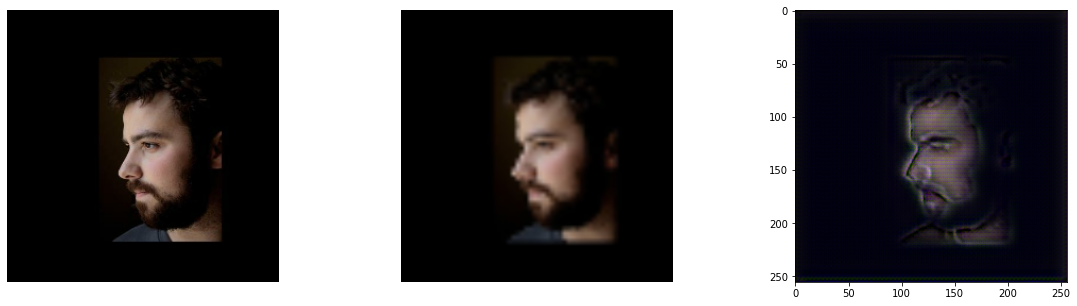

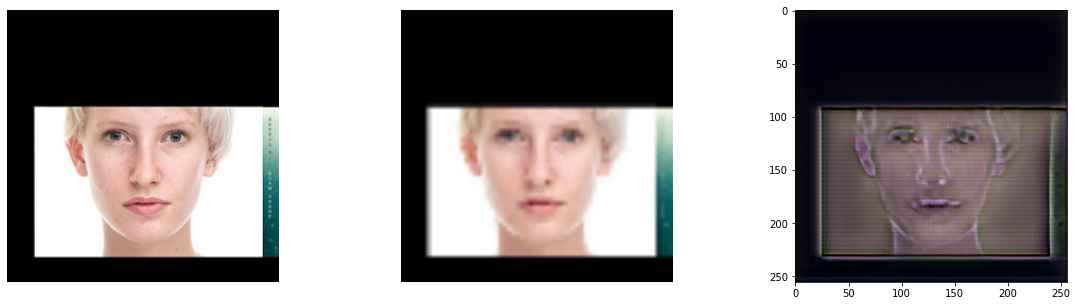

In [21]:
for x in train_data.take(2):
  lr,x=build_data(x)
  fig=plt.figure(figsize=(20,5))

  #plot original image
  plt.subplot(1,3,1)
  plt.imshow(x)
  plt.axis('off')

  #Plot downsampled image
  plt.subplot(1,3,2)
  plt.imshow(tf.image.resize(lr,(512,512)))
  plt.axis('off')

  #Plot the output of the model
  plt.subplot(1,3,3)
  plt.imshow(tf.cast(tf.clip_by_value(tf.squeeze(generator(tf.expand_dims(lr,axis=0))*255), 0, 255), tf.uint8))
  plt.axis('on')
  plt.show()
